In [1]:
import re
import numpy as np
import math
import tensorflow as tf

from matplotlib import pyplot as plt
%matplotlib inline
import sklearn.datasets
from sklearn import preprocessing, model_selection
from sklearn.preprocessing import OneHotEncoder


# Data loading

In [2]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original', data_home='data/mnist')

In [3]:
n =2000

randidx = np.random.choice(mnist.target.shape[0], n, replace=False)

# This cell includes the splittign of training and test set.
X = mnist['data'][randidx]

shapeX = [2, 28, 28]
X = 2*(X / 255) - 1 #Normalize to -1,1

y = mnist['target'][randidx]
enc = preprocessing.OneHotEncoder()
y = enc.fit_transform(y.reshape(-1, 1)).toarray()
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.33, random_state=42)

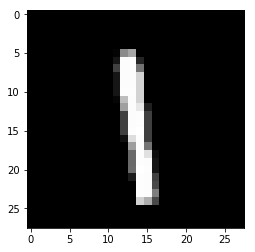

In [4]:
plt.imshow(X[0].reshape(shapeX[1],shapeX[2]), plt.cm.gray)

# Optimal Encoding

In [5]:
from networks import MLP
from OptimalEncoding import OptimalEncoding

Instructions for updating:
Use the retry module or similar alternatives.


## Autoencoding

In [6]:
n_in = X.shape[-1]
n_cts = 0
n_categorical = 10

depth = 4
widths_in = [512, 512, 512, 512]
widths_out = widths_in[::-1]

In [7]:
widths_in[::-1]

[512, 512, 512, 512]

In [8]:
encoder = MLP(n_in, 2*n_cts + n_categorical, depth, widths_in)
decoder = MLP(n_cts + n_categorical, n_in, depth, widths_out)

In [9]:
oe = OptimalEncoding(encoder, decoder, n_cts, n_categorical)

100%|██████████| 1000/1000 [01:05<00:00, 15.19it/s]


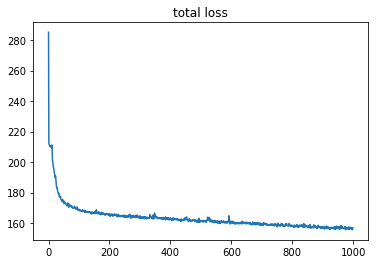

In [10]:
oe.train(X_train, epochs=1000, batch_size=64, lr=1e-2, tau_rate = 1e-4)

In [11]:
zhat = oe.encode(X_train)

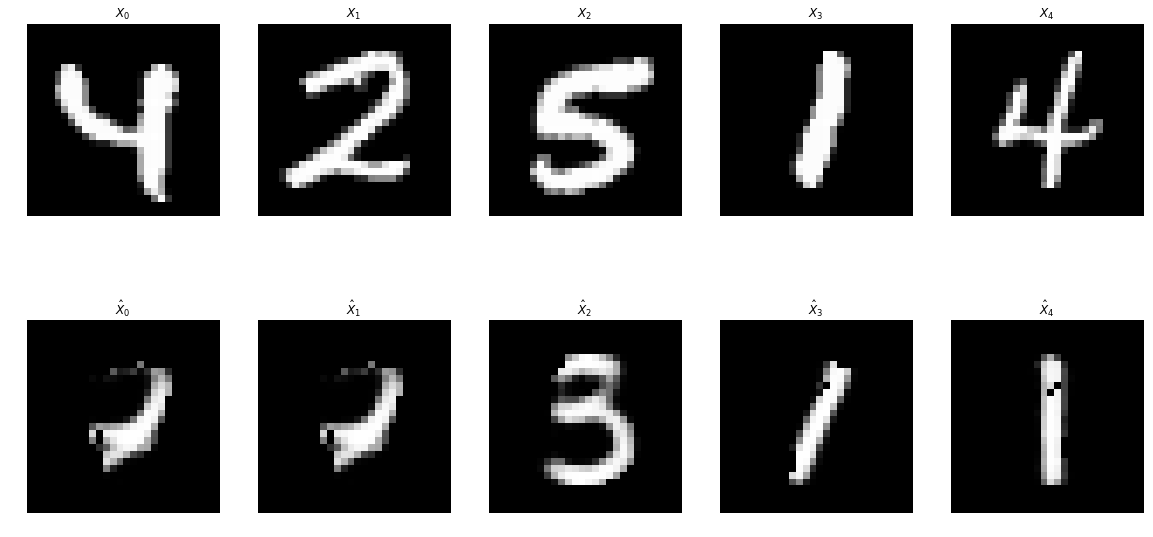

In [12]:
xhat = oe.decode(zhat)

fig, ax = plt.subplots(figsize = (20,10), nrows=2, ncols=5)
for i in range(len(ax)):
    row = ax[i]
    for j in range(len(row)):
        subplt = row[j]
        if i == 0:
            subplt.set_title("$X_%d$" %(j))
            subplt.imshow(X_train[j].reshape((shapeX[1],shapeX[2])), plt.cm.gray)
        if i == 1:
            subplt.set_title("$\hat{X}_%d$" %(j))
            subplt.imshow(xhat[j].reshape((shapeX[1],shapeX[2])), plt.cm.gray)
        
        subplt.axis('off')
        
fig.subplots_adjust(wspace=None, hspace=None)
plt.show()

In [13]:
np.mean(zhat[:,-n_categorical:], 0)

array([ 0.12537314,  0.06119403,  0.12164179,  0.0761194 ,  0.12238806,
        0.07313433,  0.11268657,  0.07462686,  0.12985075,  0.10298508], dtype=float32)

In [14]:
zhat = oe.encode(X_test)

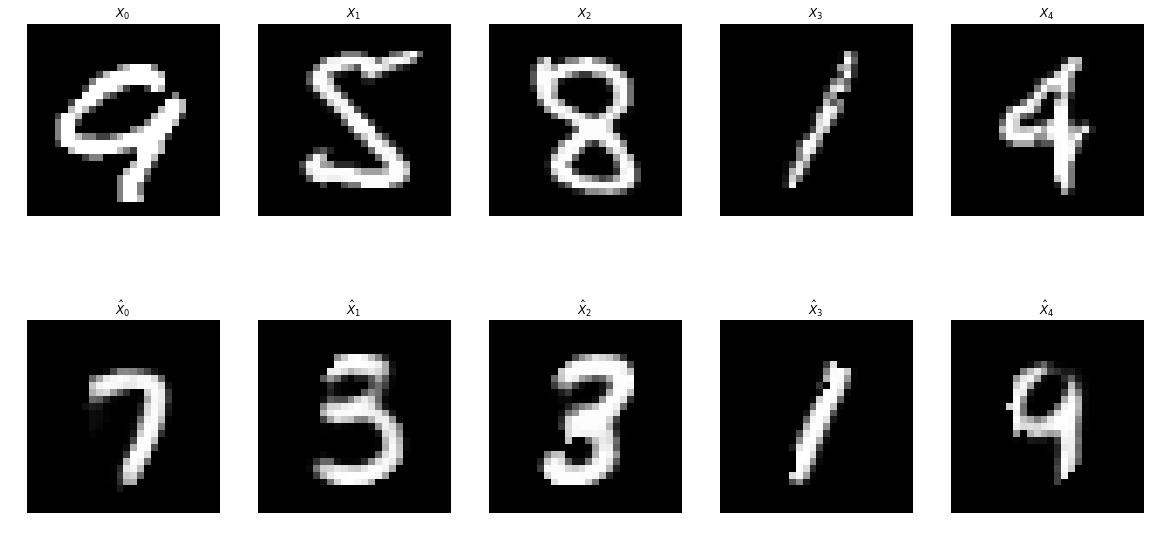

In [15]:
xhat = oe.decode(zhat)

fig, ax = plt.subplots(figsize = (20,10), nrows=2, ncols=5)
for i in range(len(ax)):
    row = ax[i]
    for j in range(len(row)):
        subplt = row[j]
        if i == 0:
            subplt.set_title("$X_%d$" %(j))
            subplt.imshow(X_test[j].reshape((shapeX[1],shapeX[2])), plt.cm.gray)
        if i == 1:
            subplt.set_title("$\hat{X}_%d$" %(j))
            subplt.imshow(xhat[j].reshape((shapeX[1],shapeX[2])), plt.cm.gray)
        
        subplt.axis('off')
        
fig.subplots_adjust(wspace=None, hspace=None)
plt.show()

In [16]:
print(np.mean(zhat, 0))

[ 0.13333334  0.04242424  0.13484849  0.05757576  0.11666667  0.09090909
  0.10454545  0.07121212  0.13939394  0.10909091]


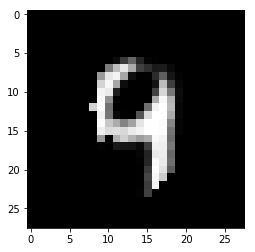

In [17]:
z_cts = np.random.normal(size=(1, n_cts))
if n_categorical > 0:
    onehot = OneHotEncoder(n_values=n_categorical, sparse=False)
    z_categorical = onehot.fit_transform(np.random.randint(n_categorical, size=(1,1)))
    z = np.hstack((z_cts, z_categorical))
else: z = z_cts
Xgen = oe.decode(z)
plt.imshow(Xgen[0].reshape(shapeX[1],shapeX[2]), plt.cm.gray)

[[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
[[ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]]
[[ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]]
[[ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]]
[[ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]]
[[ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]]
[[ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]]
[[ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]]
[[ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]]
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]]


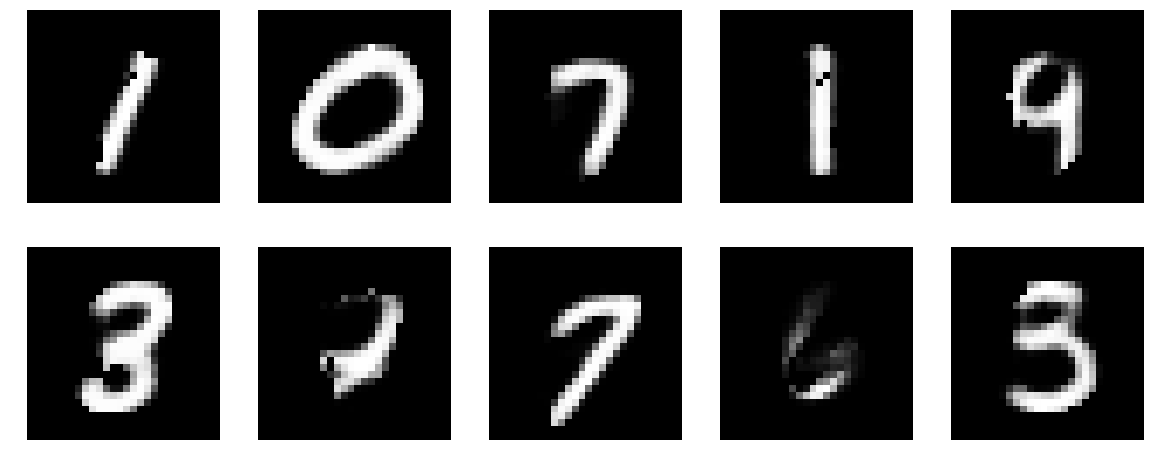

In [18]:
z_cts = np.random.normal(size=(1, n_cts))
fig, ax = plt.subplots(figsize = (20,8), nrows=2, ncols=5)
for i in range(len(ax)):
    row = ax[i]
    for j in range(len(row)):
        subplt = row[j]

        onehot = OneHotEncoder(n_values=n_categorical, sparse=False)
        z_categorical = onehot.fit_transform([[i*5+j]])
        z = np.hstack((z_cts, z_categorical))
        print(z)

        Xgen = oe.decode(z)
        subplt.imshow(Xgen[0].reshape(shapeX[1],shapeX[2]), plt.cm.gray)

        subplt.axis('off')
        
fig.subplots_adjust(wspace=None, hspace=None)
plt.show()